In [ ]:
# pip install mido pretty_midi  tensorflow keras

In [17]:
import os
import pretty_midi
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

In [18]:
#function to load midi files from a folder, because of the nesting of the folders  add a root file walk so as to go through the directory 
def load_midi_files(directory):
    midi_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.mid'):
                file_path = os.path.join(root, file)
                try:
                    midi_files.append(pretty_midi.PrettyMIDI(file_path))
                except:
                    print(f"Could not parse {file_path}")
    return midi_files



midi_files = load_midi_files(r"C:\Users\kaise\Downloads\midi files\lmd_matched\A\A")

C:\Users\kaise\AppData\Roaming\Python\Python311\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Could not parse C:\Users\kaise\Downloads\midi files\lmd_matched\A\A\M\TRAAMBM128F4248306\1d2b92aa9e454280cca21fae99ebce8e.mid
Could not parse C:\Users\kaise\Downloads\midi files\lmd_matched\A\A\M\TRAAMBM128F4248306\cfdc20d17d7ae95f3493dbf1c3177148.mid
Could not parse C:\Users\kaise\Downloads\midi files\lmd_matched\A\A\S\TRAASMT12903CC238B\913503a9957064c04d5cc72e351bf485.mid


In [4]:
#function to exttract the notes in a midi file so asto have data points to work with 
def extract_notes(midi):
    notes = []
    for instrument in midi.instruments:
        if not instrument.is_drum:
            for note in instrument.notes:
                notes.append((note.start, note.end, note.pitch, note.velocity))
    return notes

In [5]:
#loop thought the midi from extracted midi files to get the notes data before normalising with minmax scaler
all_notes = []
for midi in midi_files:
    all_notes.extend(extract_notes(midi))
if not all_notes:
    raise ValueError("No valid notes found in the MIDI files.")

In [6]:
def check_midi_files(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.mid'):
                file_path = os.path.join(root, file)
                try:
                    midi_data = pretty_midi.PrettyMIDI(file_path)
                    print(f"Checking file: {file_path}")
                    
                    # Basic information
                    print(f"  Duration: {midi_data.get_end_time()} seconds")
                    print(f"  Instruments: {len(midi_data.instruments)}")
                    
                    # Check instruments and notes
                    for i, instrument in enumerate(midi_data.instruments):
                        if not instrument.is_drum:
                            print(f"  Instrument {i}: {pretty_midi.program_to_instrument_name(instrument.program)}")
                            print(f"    Notes: {len(instrument.notes)}")
                            
                           
                            for note in instrument.notes[:5]:  # Print first 5 notes
                                print(f"      Note - start: {note.start}, end: {note.end}, pitch: {note.pitch}, velocity: {note.velocity}")
                        
                except Exception as e:
                    print(f"Could not parse {file_path}: {e}")

In [16]:
#check_midi_files(r"C:\Users\kaise\Downloads\midi files\lmd_matched\A\A")

Checking file: C:\Users\kaise\Downloads\midi files\lmd_matched\A\A\A\TRAAAGR128F425B14B\1d9d16a9da90c090809c153754823c2b.mid
  Duration: 218.0 seconds
  Instruments: 17
  Instrument 0: Synth Brass 1
    Notes: 640
      Note - start: 0.018229166666666664, end: 0.18489583333333331, pitch: 69, velocity: 100
      Note - start: 0.2552083333333333, end: 0.4375, pitch: 76, velocity: 100
      Note - start: 0.5052083333333333, end: 0.6875, pitch: 74, velocity: 100
      Note - start: 0.7317708333333333, end: 0.8697916666666666, pitch: 72, velocity: 100
      Note - start: 0.8697916666666666, end: 1.0416666666666665, pitch: 69, velocity: 100
  Instrument 1: Synth Brass 1
    Notes: 128
      Note - start: 0.2552083333333333, end: 0.4114583333333333, pitch: 69, velocity: 80
      Note - start: 0.4895833333333333, end: 0.6640625, pitch: 76, velocity: 80
      Note - start: 0.7864583333333333, end: 0.9661458333333333, pitch: 74, velocity: 80
      Note - start: 0.9921875, end: 1.1692708333333333

C:\Users\kaise\AppData\Roaming\Python\Python311\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Checking file: C:\Users\kaise\Downloads\midi files\lmd_matched\A\A\A\TRAAAGR128F425B14B\dac3cdd0db6341d8dc14641e44ed0d44.mid
  Duration: 284.0052083333333 seconds
  Instruments: 9
  Instrument 0: Acoustic Guitar (steel)
    Notes: 2044
      Note - start: 0.0, end: 0.25, pitch: 52, velocity: 100
      Note - start: 0.0, end: 0.25, pitch: 55, velocity: 100
      Note - start: 0.0, end: 0.25, pitch: 60, velocity: 100
      Note - start: 0.0, end: 0.25, pitch: 62, velocity: 100
      Note - start: 0.25, end: 0.5, pitch: 64, velocity: 100
  Instrument 1: Kalimba
    Notes: 81
      Note - start: 4.0, end: 4.25, pitch: 69, velocity: 100
      Note - start: 4.25, end: 4.5, pitch: 69, velocity: 100
      Note - start: 4.5, end: 4.75, pitch: 69, velocity: 100
      Note - start: 4.75, end: 5.0, pitch: 69, velocity: 100
      Note - start: 5.25, end: 5.5, pitch: 69, velocity: 100
  Instrument 2: Alto Sax
    Notes: 630
      Note - start: 8.0, end: 8.25, pitch: 60, velocity: 127
      Note - st

In [8]:
#get start times, end times, pitches and velocities for the notes
start_times = [note[0] for note in all_notes]
end_times = [note[1] for note in all_notes]
pitches = [note[2] for note in all_notes]
velocities = [note[3] for note in all_notes]

In [9]:
#scale the data  from above step
scaler = MinMaxScaler()
start_times = scaler.fit_transform(np.array(start_times).reshape(-1, 1)).flatten()
end_times = scaler.transform(np.array(end_times).reshape(-1, 1)).flatten()
pitches = scaler.fit_transform(np.array(pitches).reshape(-1, 1)).flatten()
velocities = scaler.fit_transform(np.array(velocities).reshape(-1, 1)).flatten()

In [10]:
normalized_notes = np.stack([start_times, end_times, pitches, velocities], axis=1)

In [11]:
normalized_notes

array([[3.96677085e-05, 4.02343901e-04, 6.38888889e-01, 7.85714286e-01],
       [5.55347919e-04, 9.52025004e-04, 7.03703704e-01, 7.85714286e-01],
       [1.09936221e-03, 1.49603929e-03, 6.85185185e-01, 7.85714286e-01],
       ...,
       [5.04587384e-01, 5.05324786e-01, 5.64814815e-01, 8.80952381e-01],
       [5.06340150e-01, 5.07077552e-01, 5.64814815e-01, 5.79365079e-01],
       [5.08104401e-01, 5.08841803e-01, 5.64814815e-01, 2.85714286e-01]])

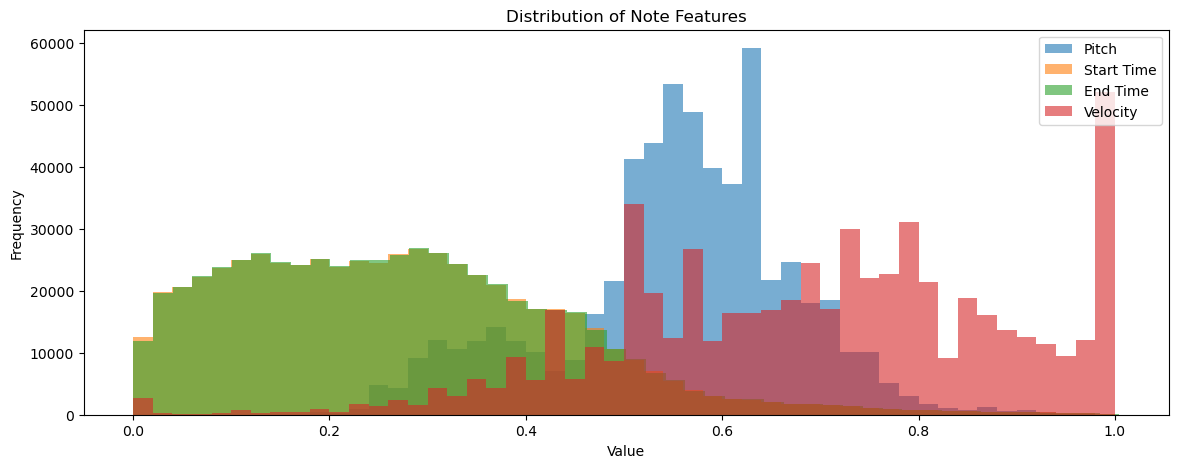

In [12]:
plt.figure(figsize=(14, 5))
plt.hist(pitches, bins=50, alpha=0.6, label='Pitch')
plt.hist(start_times, bins=50, alpha=0.6, label='Start Time')
plt.hist(end_times, bins=50, alpha=0.6, label='End Time')
plt.hist(velocities, bins=50, alpha=0.6, label='Velocity')
plt.legend(loc='upper right')
plt.title('Distribution of Note Features')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [13]:
sequence_length = 100

def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        target = data[i + seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

X, y = create_sequences(normalized_notes, sequence_length)

In [14]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(256, input_shape=(sequence_length, 4), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(256))
model.add(Dense(4))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

C:\Users\kaise\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 256)       │       267,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 793,604 (3.03 MB)

 Trainable params: 793,604 (3.03 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.fit(X, y, epochs=10, batch_size=1000, validation_split=0.2)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 785s 2s/step - loss: 0.0028 - val_loss: 0.0027
Epoch 2/10
339/469 ━━━━━━━━━━━━━━━━━━━━ 3:13 1s/step - loss: 0.0028

KeyboardInterrupt: 

In [39]:
def generate_music(model, seed_sequence, length):
    generated = []
    current_sequence = seed_sequence
    for _ in range(length):
        predicted = model.predict(current_sequence.reshape(1, sequence_length, 4))[0]
        generated.append(predicted)
        current_sequence = np.vstack([current_sequence[1:], predicted])
    return generated

# Using the last sequence in the training data as the seed sequence
seed_sequence = X[-2]
generated_music = generate_music(model, seed_sequence, 500)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

In [40]:
def save_to_midi(generated_notes, output_file):
    midi = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=0)

    for note in generated_notes:
        start, end, pitch, velocity = scaler.inverse_transform(note.reshape(1, -1))[0]
        note = pretty_midi.Note(
            velocity=int(velocity),
            pitch=int(pitch),
            start=start,
            end=end
        )
        instrument.notes.append(note)
    
    midi.instruments.append(instrument)
    midi.write(output_file)

save_to_midi(generated_music, 'generated_music.mid')